In [0]:
#dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/Churn_Modelling.csv

In [0]:
#Sử dụng PySpark để đọc dữ liệu vào DataFrame
from pyspark.sql import SparkSession
#Khởi tạo SparkSession
spark = SparkSession.builder.getOrCreate()
#Đọc dữ liệu từ file CSV
data = spark.read.csv("dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/Churn_Modelling.csv", header=True, inferSchema=True)

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

Number of rows:  10000
Number of columns:  14
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+----

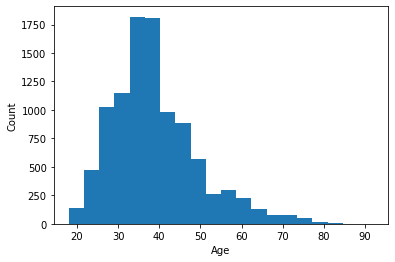

In [0]:
#Thực hiện một số thống kê, trực quan hóa để hiểu dữ liệu
#Hiển thị thông tin cấu trúc của DataFrame
data.printSchema()
#Hiển thị số lượng dòng và cột trong DataFrame
print("Number of rows: ", data.count())
print("Number of columns: ", len(data.columns))
#Hiển thị một số dòng đầu tiên trong DataFrame
data.show()
#Thực hiện các thống kê mô tả tổng quan của DataFrame
data.describe().show()
#Trực quan hóa dữ liệu bằng biểu đồ, ví dụ: histogram của cột Age
import matplotlib.pyplot as plt
age_values = data.select("Age").rdd.flatMap(lambda x: x).collect()
plt.hist(age_values, bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [0]:
#Tiền xử lý dữ liệu
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
#Loại bỏ cột RowNumber, CustomerId
data = data.drop("RowNumber", "CustomerId")
#Chuyển đổi giá trị chuỗi thành số
string_columns = ["Geography", "Gender"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in string_columns]
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)
#Chuyển đổi các biến độc lập thành vector
feature_columns = ["CreditScore", "Geography_index", "Gender_index", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

In [0]:
#Chia dữ liệu thành tập huấn luyện và tập kiểm tra(tỉ lệ 70/)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)

In [0]:
#Sử dụng Logistic Regression để huấn luyện mô hình
from pyspark.ml.classification import LogisticRegression
#Khởi tạo mô hình Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Exited")
#Huấn luyện mô hình trên tập huấn luyện
model = lr.fit(train_data)

In [0]:
#Đánh giá hiệu suất của mô hình trên tập kiểm tra
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#Tạo một evaluator với metricName='accuracy'
evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")
#Tính toán accuracy trên tập kiểm tra
accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)

Accuracy:  0.8137638617090672


In [0]:
#Tạo pipeline để xây dựng mô hình từ bước chuẩn hóa dữ liệu đến chọn mô hình học máy
#Tạo pipeline
pipeline = Pipeline(stages=indexers + [assembler] + [lr])
#Huấn luyện mô hình từ dữ liệu huấn luyện
model = pipeline.fit(train_data)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-2639336321475893>:5
      3 pipeline = Pipeline(stages=indexers + [assembler] + [lr])
      4 #Huấn luyện mô hình từ dữ liệu huấn luyện
----> 5 model = pipeline.fit(train_data)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/spark/python/pyspark/ml/base.py:205, in Estimator.fit(self, dataset, params)
    203         return self.copy(params)._fit(dataset)
    204     else:
--> 205         return self._fit(dataset)
    206 else:
    207     raise TypeError(
    208         "Params must be either a param map or a list/tuple of param maps, "

In [0]:
#Lưu mô hình xây dựng bao gồm dữ liệu đã huấn luyệ
model.save("dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/model")

In [0]:
#Mở lại mô hình đã lưu và dự đoán lại cho dữ liệu test
from pyspark.ml import PipelineModel
#Load mô hình đã lưu
saved_model = PipelineModel.load("dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/model")
#Dự đoán lại cho dữ liệu test
predictions = saved_model.transform(test_data)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-2639336321475895>:4
      2 from pyspark.ml import PipelineModel
      3 #Load mô hình đã lưu
----> 4 saved_model = PipelineModel.load("dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/model")
      5 #Dự đoán lại cho dữ liệu test
      6 predictions = saved_model.transform(test_data)

File /databricks/spark/python/pyspark/ml/util.py:447, in MLReadable.load(cls, path)
    444 @classmethod
    445 def load(cls, path: str) -> RL:
    446     """Reads an ML instance from the input path, a shortcut of `read().load(path)`."""
--> 447     return cls.read().load(path)

File /databricks/spark/python/pyspark/ml/pipeline.py:284, in PipelineModelReader.load(self, path)
    282 metadata = DefaultParamsReader.loadMetadata(path, self.sc)
    283 if "language" not in metadata["paramMap"] or metadata["paramMap"]["language"] != "Python